In [1]:
# pip install pycatch22

## Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pycatch22 import catch22_all

In [2]:
df = pd.read_csv('imdb_ts.csv')
df

,id,0,1,2,3,4,5,6,7,8,...,93,94,95,96,97,98,99,rating,genre,rating_category
0,tt0062622,57057.0,65469.0,71642.0,73025.0,74060.0,49472.0,30258.0,28036.0,25824.0,...,10709.0,11042.0,11388.0,11847.0,12404.0,13679.0,15056.0,8.3,"['Adventure', 'Sci-Fi']",High
1,tt0064816,1923.0,2422.0,2853.0,2947.0,3054.0,2844.0,2617.0,1998.0,1277.0,...,637.0,734.0,857.0,785.0,724.0,713.0,699.0,7.1,"['Crime', 'Drama', 'Romance']",High
2,tt0088178,332925.0,302503.0,267264.0,261879.0,256608.0,196530.0,112728.0,117384.0,123024.0,...,6784.0,7253.0,7776.0,9632.0,11212.0,9010.0,6431.0,8.7,"['Documentary', 'Music']",High
3,tt0145487,682857.0,407032.0,78058.0,81732.0,86772.0,83724.0,79940.0,39656.0,6974.0,...,21094.0,10995.0,1586.0,1421.0,1177.0,970.0,802.0,7.4,"['Action', 'Adventure', 'Sci-Fi']",High
4,tt0359950,7813372.0,6274563.0,4781588.0,4655046.0,4535301.0,4650574.0,4758452.0,4069428.0,3471755.0,...,88635.0,68347.0,45367.0,28915.0,15494.0,16155.0,16853.0,7.3,"['Adventure', 'Comedy', 'Drama']",High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,tt9731534,1077363.0,1061148.0,1043451.0,912840.0,738595.0,508118.0,296236.0,318113.0,341113.0,...,2396.0,2425.0,2461.0,2223.0,1920.0,1991.0,2051.0,6.4,"['Horror', 'Mystery', 'Thriller']",Medium
1130,tt9735462,56775.0,57750.0,58828.0,53549.0,48484.0,37340.0,19243.0,30804.0,55897.0,...,739.0,618.0,488.0,636.0,883.0,904.0,920.0,6.3,"['Biography', 'Comedy', 'Drama']",Medium
1131,tt9764362,3595005.0,3401235.0,3221227.0,2645775.0,2188725.0,1681250.0,1030698.0,1138724.0,1290788.0,...,345246.0,257388.0,182883.0,165311.0,144119.0,128009.0,111756.0,7.2,"['Comedy', 'Horror', 'Thriller']",High
1132,tt9784798,528167.0,617409.0,696127.0,741481.0,802782.0,527997.0,177249.0,141753.0,100026.0,...,10108.0,10511.0,10878.0,7491.0,3752.0,5237.0,6592.0,7.4,"['Biography', 'Drama', 'History']",High


In [3]:
# Prepare the data
time_series_data = df.iloc[:,1:101].values
time_series_data = np.log1p(time_series_data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(time_series_data.T).T # Chiara's suggestion: z-score per serie

In [4]:
# Compute catch22 features for each time series
features_list = []
for ts in scaled_data:
    features = catch22_all(ts)['values']  # Extract 22 features
    features_list.append(features)

# Convert to NumPy array
scaled_features = np.array(features_list)

In [31]:
scaled_features

array([[-0.64368094, -0.87421419,  3.88909553, ...,  0.68571429,
         0.19634954,  0.64657671],
       [-0.72866651, -0.50433398,  2.90375495, ...,  0.65714286,
         0.39269908,  0.78429773],
       [-0.61704438,  0.07439725, 22.3631298 , ...,  0.6       ,
         0.04908739,  0.25400098],
       ...,
       [-0.65063317, -0.42912637, 17.10766745, ...,  0.6       ,
         0.04908739,  0.4372013 ],
       [ 0.05545212,  0.29375575,  4.64994838, ...,  0.6       ,
         0.09817477,  0.49437036],
       [ 0.74206355, -0.19726391, 20.20976407, ...,  0.37142857,
         0.04908739,  0.25194054]])

## Finding the optimal K

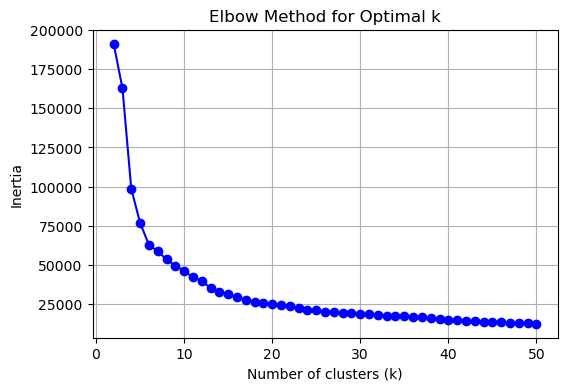

In [5]:
# Elbow method
inertia = []
K = range(2, 51)  # Try k from 2 to 51
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

k=2: Silhouette Score=0.6773
k=3: Silhouette Score=0.5124
k=4: Silhouette Score=0.4765
k=5: Silhouette Score=0.4593
k=6: Silhouette Score=0.5083
k=7: Silhouette Score=0.5082
k=8: Silhouette Score=0.4194
k=9: Silhouette Score=0.4264
k=10: Silhouette Score=0.4327
k=11: Silhouette Score=0.4789
k=12: Silhouette Score=0.4813
k=13: Silhouette Score=0.4865
k=14: Silhouette Score=0.4946
k=15: Silhouette Score=0.4965
k=16: Silhouette Score=0.4327
k=17: Silhouette Score=0.4290
k=18: Silhouette Score=0.4307
k=19: Silhouette Score=0.4039
k=20: Silhouette Score=0.3724
k=21: Silhouette Score=0.3463
k=22: Silhouette Score=0.3452
k=23: Silhouette Score=0.3880
k=24: Silhouette Score=0.3627
k=25: Silhouette Score=0.3506
k=26: Silhouette Score=0.3528
k=27: Silhouette Score=0.3331
k=28: Silhouette Score=0.3357
k=29: Silhouette Score=0.3331
k=30: Silhouette Score=0.3341
k=31: Silhouette Score=0.3237
k=32: Silhouette Score=0.3236
k=33: Silhouette Score=0.3249
k=34: Silhouette Score=0.3259
k=35: Silhouette S

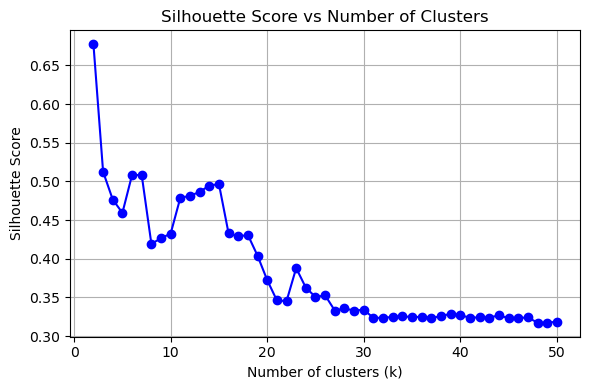

In [6]:
# Compute silhouette scores for k = 2 to 10
silhouette_scores = []
k_values = range(2, 51)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.tight_layout()
plt.savefig('silhouette_scores.png')

# Print silhouette scores
for k, score in zip(k_values, silhouette_scores):
    print(f"k={k}: Silhouette Score={score:.4f}")

## Cluster = 4

In [8]:
# Fit K-means with chosen number of clusters
optimal_k = 4  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

<Figure size 1000x600 with 0 Axes>

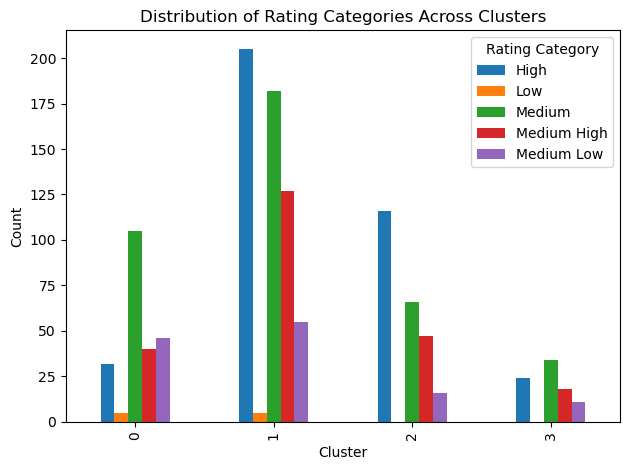

In [9]:
# Add cluster labels to the original dataframe
df['cluster_4'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_4', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [10]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)

Cluster distribution: {0: 228, 1: 574, 2: 245, 3: 87}


In [11]:
# Show the distribution table
print(distribution)

rating_category  High  Low  Medium  Medium High  Medium Low
cluster_4                                                  
0                  32    5     105           40          46
1                 205    5     182          127          55
2                 116    0      66           47          16
3                  24    0      34           18          11


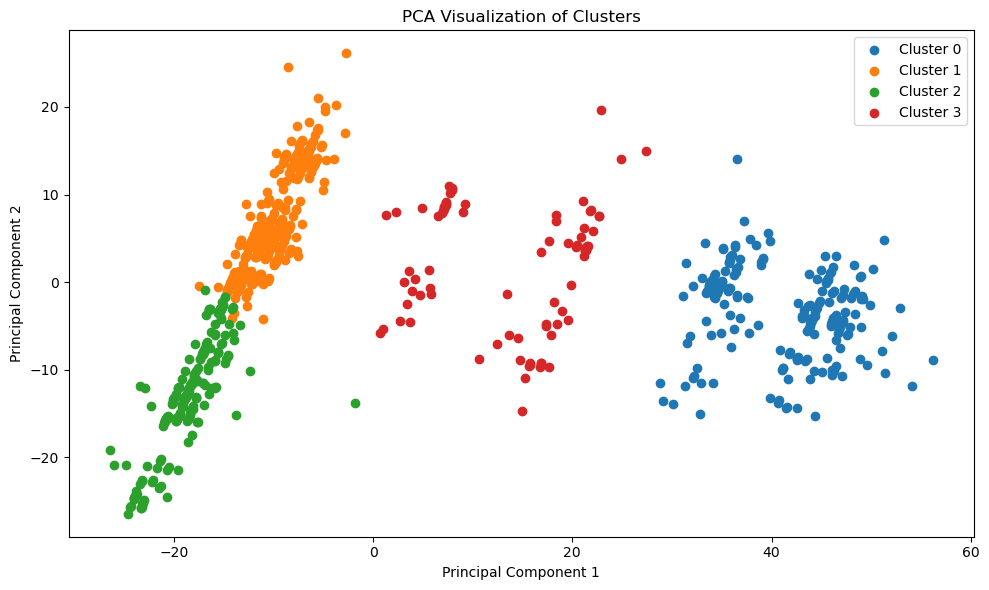

In [12]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

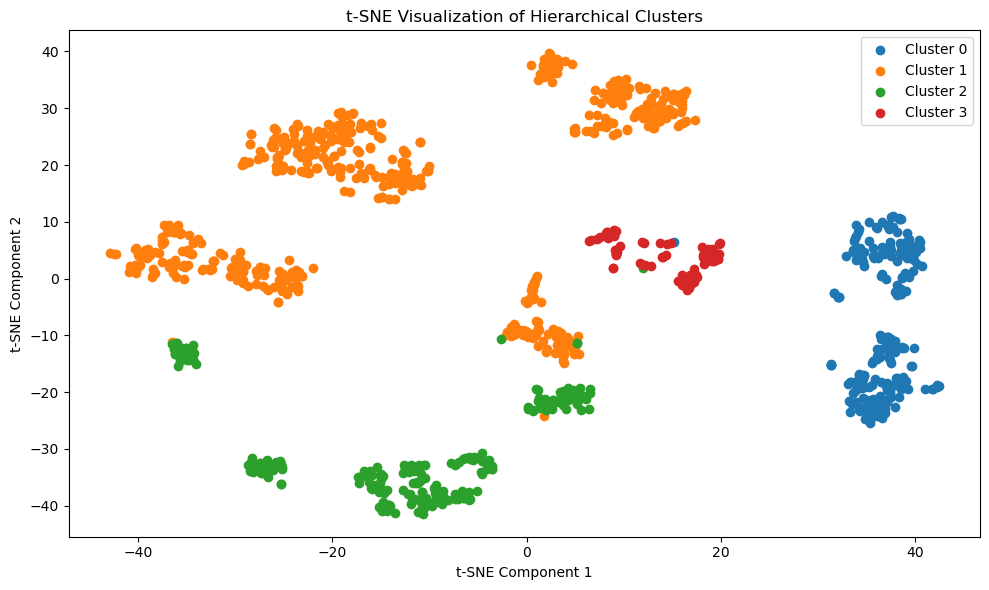

In [13]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_features)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 5

In [14]:
# Fit K-means with chosen number of clusters
optimal_k = 5  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

<Figure size 1000x600 with 0 Axes>

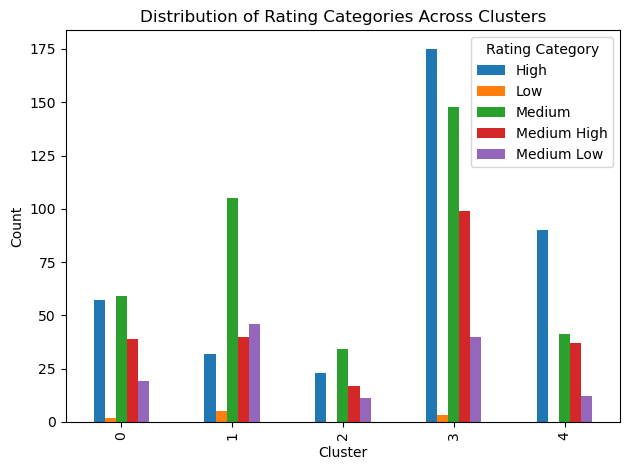

In [15]:
# Add cluster labels to the original dataframe
df['cluster_5'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_5', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [16]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {0: 176, 1: 228, 2: 85, 3: 465, 4: 180}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_5                                                  
0                  57    2      59           39          19
1                  32    5     105           40          46
2                  23    0      34           17          11
3                 175    3     148           99          40
4                  90    0      41           37          12


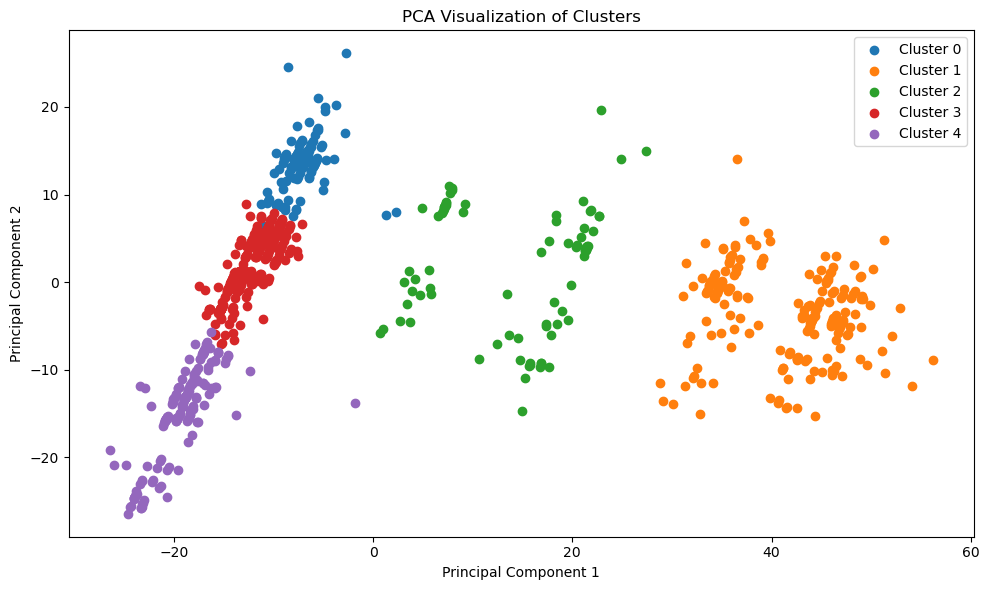

In [17]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

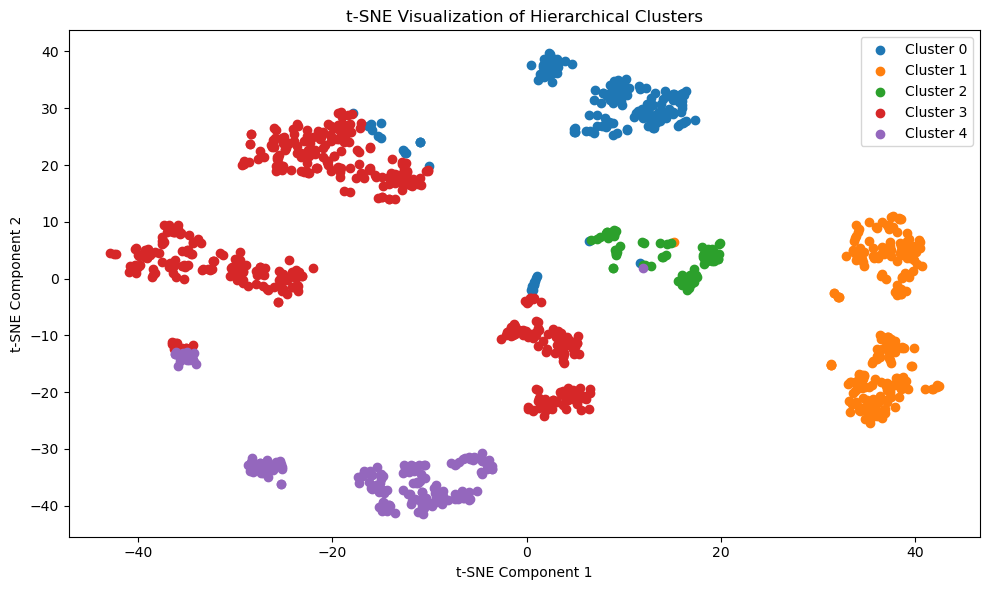

In [18]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_features)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 6

In [19]:
# Fit K-means with chosen number of clusters
optimal_k = 6  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

<Figure size 1000x600 with 0 Axes>

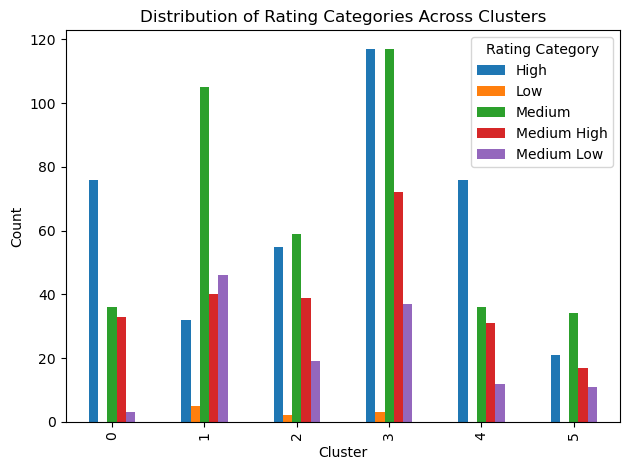

In [20]:
# Add cluster labels to the original dataframe
df['cluster_6'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_6', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [21]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {0: 148, 1: 228, 2: 174, 3: 346, 4: 155, 5: 83}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_6                                                  
0                  76    0      36           33           3
1                  32    5     105           40          46
2                  55    2      59           39          19
3                 117    3     117           72          37
4                  76    0      36           31          12
5                  21    0      34           17          11


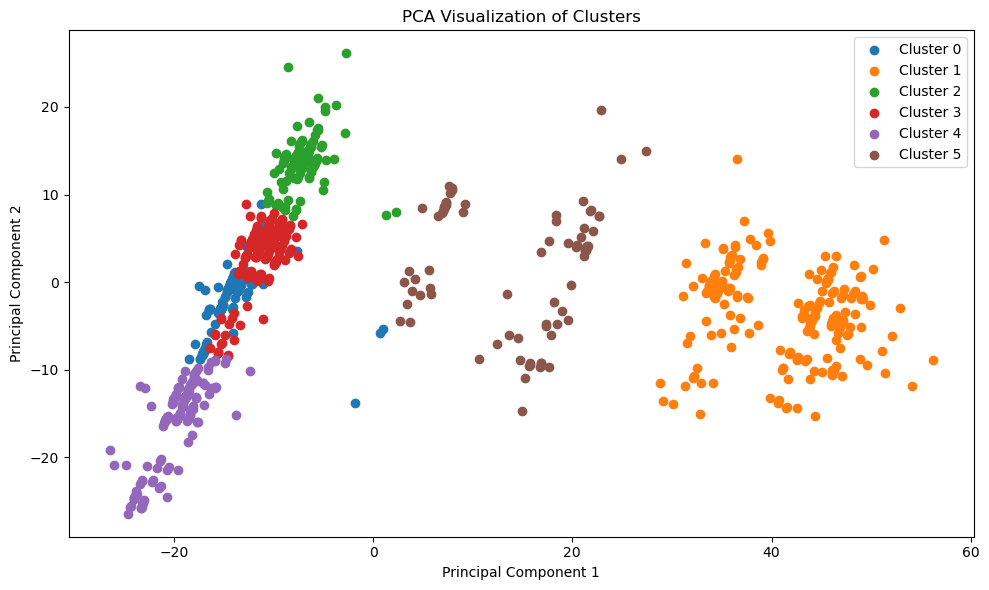

In [22]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

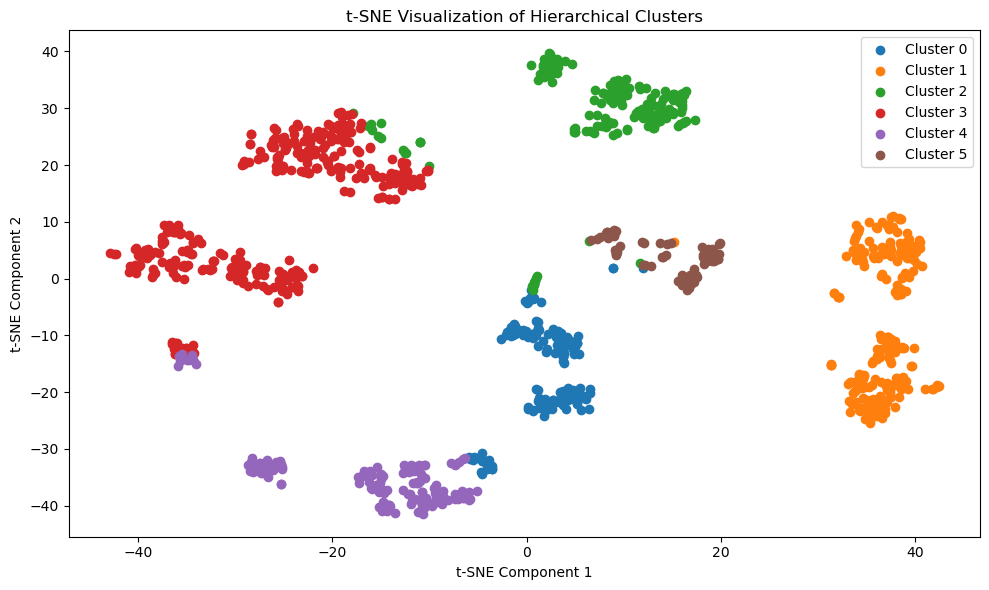

In [23]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_features)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')

## Cluster = 8

In [24]:
# Fit K-means with chosen number of clusters
optimal_k = 8  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

<Figure size 1000x600 with 0 Axes>

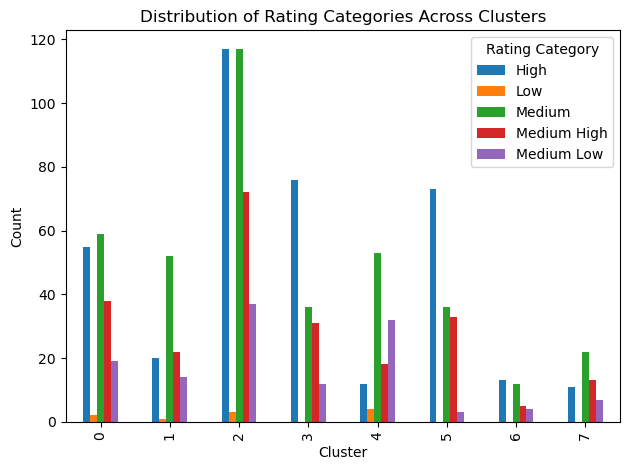

In [25]:
# Add cluster labels to the original dataframe
df['cluster_6'] = cluster_labels

# Compute distribution of rating labels within each cluster
distribution = df.groupby(['cluster_6', 'rating_category']).size().unstack(fill_value=0)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
distribution.plot(kind='bar', stacked=False)
plt.title('Distribution of Rating Categories Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating Category')
plt.tight_layout()
plt.savefig('rating_distribution_by_cluster.png')

In [26]:
# value counts of cluster labels
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print("Cluster distribution:", cluster_distribution)
# Show the distribution table
print(distribution)

Cluster distribution: {0: 173, 1: 109, 2: 346, 3: 155, 4: 119, 5: 145, 6: 34, 7: 53}
rating_category  High  Low  Medium  Medium High  Medium Low
cluster_6                                                  
0                  55    2      59           38          19
1                  20    1      52           22          14
2                 117    3     117           72          37
3                  76    0      36           31          12
4                  12    4      53           18          32
5                  73    0      36           33           3
6                  13    0      12            5           4
7                  11    0      22           13           7


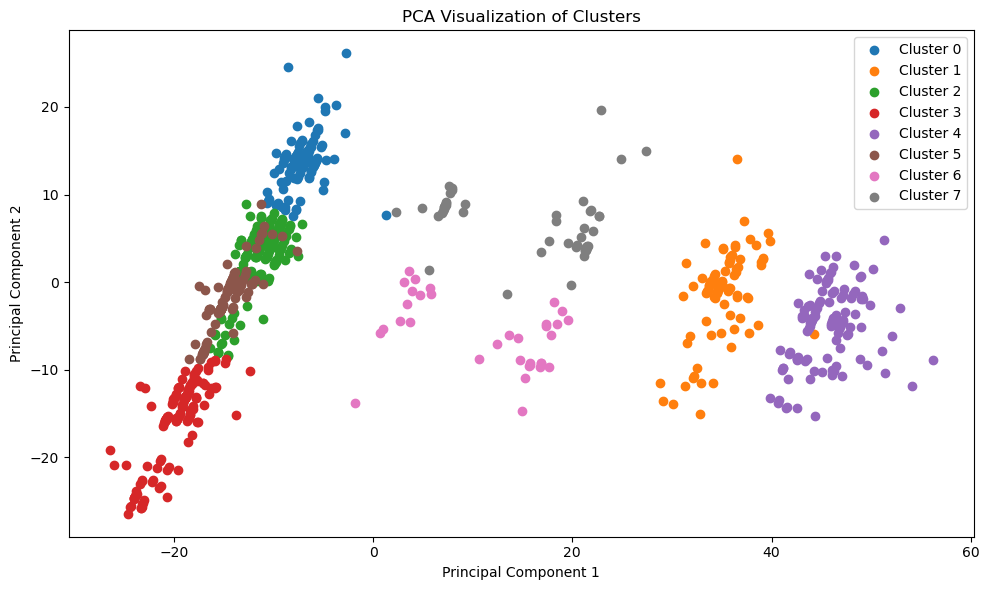

In [29]:
# Apply PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_features)

# Plot PCA results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_results[cluster_labels == cluster, 0],
                pca_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('pca_clusters.png')

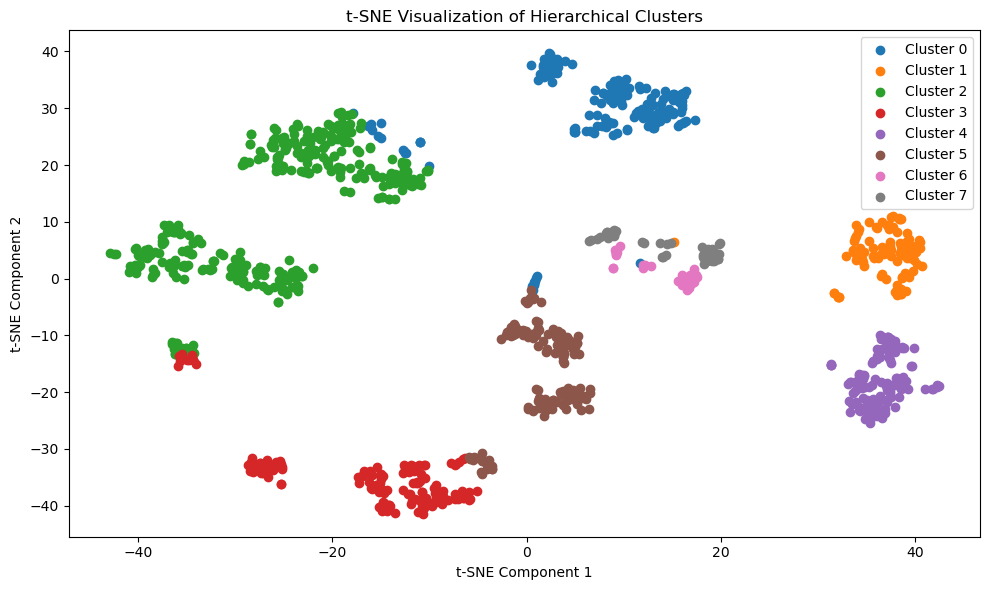

In [30]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_features)

# Plot t-SNE results colored by cluster labels
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(tsne_results[cluster_labels == cluster, 0],
                tsne_results[cluster_labels == cluster, 1],
                label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('tsne_hierarchical_clusters.png')